## 1. 2D/3D Transformation

### 1.1. 2D Transformation

In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

You need to implement the function "get_transform_matrix".

In [2]:
def get_transform_matrix(rotate_angle, scale_factor, center_point):
  """
  Get the transformation matrix (scaling, rotate in center) to transform image
  Inputs:
    rotate_angle: float: rotation angle degree
    scale_factor: int: scale image
    center_points: list: [x, y]: co-ordinate of center point
  Returns:
    The numpy homogeneous transform matrix: (3x3)
  """
  x, y = center_point
  cos = np.cos(rotate_angle)
  sin = np.sin(rotate_angle)
  s = scale_factor
  normal = np.array([[s*cos, s*sin, x - s*x*cos - s*y*sin],
                     [-s*sin, s*cos, y + s*x*sin - s*y*cos],
                     [0, 0, 1]])
  return scale_factor * normal

In [3]:
def process_image(image, scale_factor=1, rotate_angle=15):
  height, width = image.shape[:2]
  center = (width/2, height/2)
  transform_matrix = get_transform_matrix(rotate_angle, scale_factor, center)
  cv2_wrap_matrix = transform_matrix[:2, :]
  rotated_image = cv2.warpAffine(src=image, M=cv2_wrap_matrix, dsize=(width, height))
  return rotated_image

def show_imgs(rotated_img, orgin_img):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
  axes[0].imshow(orgin_img)
  axes[1].imshow(rotated_img)

  axes[0].set_axis_off()
  axes[1].set_axis_off()

def run(img_path):
  image = cv2.imread(img_path)
  rotated_image = process_image(image)
  show_imgs(rotated_image, image)

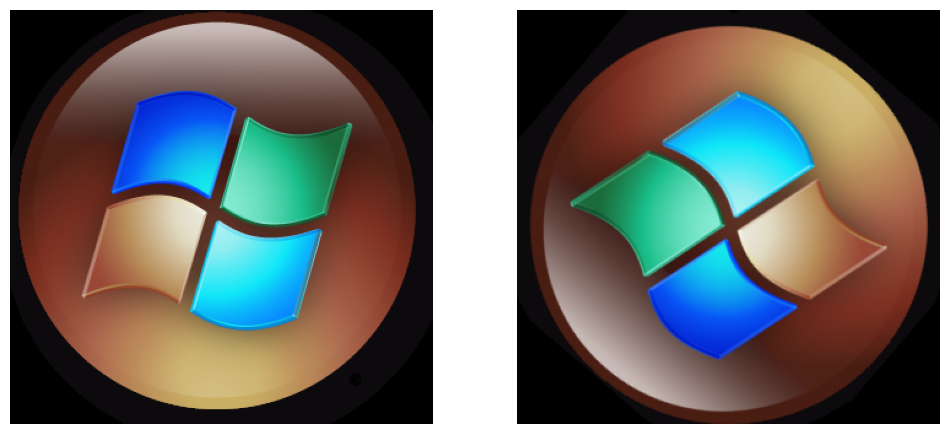

In [4]:
img_path = "microsoft.png"
run(img_path)

###1.2. 3D Tranformation




In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
def load_data():
  bunny = o3d.data.BunnyMesh()
  mesh = o3d.io.read_triangle_mesh(bunny.path)
  mesh.compute_vertex_normals()
  pcl = mesh.sample_points_poisson_disk(number_of_points=10000)
  return pcl


def visualize_result(pcl):
  if isinstance(pcl, np.ndarray):
    point_cloud_o3d = o3d.geometry.PointCloud()
    point_cloud_o3d.points = o3d.utility.Vector3dVector(pcl)
    o3d.visualization.draw_plotly([point_cloud_o3d],
                                up=[0, 1, 0],
                                front=[0, 0, 1],
                                lookat=[0, 0.1, 0],
                                zoom=0.4
                                )
  else:
    o3d.visualization.draw_plotly([pcl],
                                up=[0, 1, 0],
                                front=[0, 0, 1],
                                lookat=[0, 0.1, 0],
                                zoom=0.4
                                )


def rotate_oz_3D_object(point_3d, rotate_angle):
  """
    Rotate object around Oz
    Inputs:
      point_3d: numpy array: shape (N, 3), N is number of points
      rotate_angle: float: rotate angle degree
    Outputs:
      rotated_point_3d: numpy array: shape (N, 3), N is number of points.
  To do:
    1. Create homogeneous rotated matrix (4x4)
    2. Convert point_3d into the homogeneous coordinate
    3. Matrix multiplication to get the result.
  """
  cos = np.cos(rotate_angle)
  sin = np.sin(rotate_angle)
  homogeneous = np.array([[cos, sin, 0, 0],
                          [-sin, cos, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
  ones = np.ones((point_3d.shape[0], 1))
  point_3d = np.concatenate([point_3d, ones], axis=1)
  point_3d = np.dot(homogeneous, point_3d.T)
  return point_3d.T[:, :-1]

In [7]:
pcl = load_data()
np_pcl = np.asarray(pcl.points)
rotated_np_pcl = rotate_oz_3D_object(np_pcl, 45)

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/BunnyMesh.ply
[Open3D INFO] Downloaded to /home/lvdthieu/open3d_data/download/BunnyMesh/BunnyMesh.ply


In [8]:
visualize_result(np_pcl)
visualize_result(rotated_np_pcl)

## 2. Camera calibration

In [9]:
import numpy as np
import cv2
import glob
from pathlib import Path
import os

You need to upload images

In [10]:
# need to supply,  numpy array,  need to have shape ((49, 3) if use the chessboard provided)
world_points = np.zeros((1, 49, 3), np.float32)
world_points[0,:,:2] = np.mgrid[0:14:2, 0:14:2].T.reshape(-1, 2)
print(world_points.shape)
print(world_points)


(1, 49, 3)
[[[ 0.  0.  0.]
  [ 2.  0.  0.]
  [ 4.  0.  0.]
  [ 6.  0.  0.]
  [ 8.  0.  0.]
  [10.  0.  0.]
  [12.  0.  0.]
  [ 0.  2.  0.]
  [ 2.  2.  0.]
  [ 4.  2.  0.]
  [ 6.  2.  0.]
  [ 8.  2.  0.]
  [10.  2.  0.]
  [12.  2.  0.]
  [ 0.  4.  0.]
  [ 2.  4.  0.]
  [ 4.  4.  0.]
  [ 6.  4.  0.]
  [ 8.  4.  0.]
  [10.  4.  0.]
  [12.  4.  0.]
  [ 0.  6.  0.]
  [ 2.  6.  0.]
  [ 4.  6.  0.]
  [ 6.  6.  0.]
  [ 8.  6.  0.]
  [10.  6.  0.]
  [12.  6.  0.]
  [ 0.  8.  0.]
  [ 2.  8.  0.]
  [ 4.  8.  0.]
  [ 6.  8.  0.]
  [ 8.  8.  0.]
  [10.  8.  0.]
  [12.  8.  0.]
  [ 0. 10.  0.]
  [ 2. 10.  0.]
  [ 4. 10.  0.]
  [ 6. 10.  0.]
  [ 8. 10.  0.]
  [10. 10.  0.]
  [12. 10.  0.]
  [ 0. 12.  0.]
  [ 2. 12.  0.]
  [ 4. 12.  0.]
  [ 6. 12.  0.]
  [ 8. 12.  0.]
  [10. 12.  0.]
  [12. 12.  0.]]]


In [11]:
image_dir_path = "images"
dectected_point_image_path = "results"

In [12]:
image_points_list = []
world_points_list = []
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
image_path_list = list(Path(image_dir_path).glob("*.jpg"))
image_path_list

for index, image_path in enumerate(image_path_list):
    img = cv2.imread(str(image_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        world_points_list.append(world_points)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        image_points_list.append(corners2)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,7), corners2, ret)
        image_path = os.path.join(dectected_point_image_path, f"img_{index}.png")
        cv2.imwrite(str(image_path), img)


In [13]:
# calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_points_list, image_points_list, gray.shape[::-1], None, None)

In [14]:
print("Intrisic camera matrix: ", np.asarray(mtx).tolist())

Intrisic camera matrix:  [[15476.471210399912, 0.0, 3117.7589766048973], [0.0, 15824.91204000823, 2199.136467822155], [0.0, 0.0, 1.0]]
